# Modelo A

por: Mariana Lozano Roncancio

# 1. Preparación del Ambiente

## Importaciones de librerias


In [42]:
import pandas as pd
#from ydata_profiling import ProfileReport

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from wordcloud import WordCloud
#from num2words import num2words
import matplotlib.pyplot as plt
import re, string, unicodedata
import matplotlib

%matplotlib inline
import numpy as np
import inflect
import joblib
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\MarianaLozano\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## Carga de Datos

In [43]:
df_original = pd.read_csv(r'C:\Users\MarianaLozano\OneDrive - NOLDATA.CO\Documents\Universidad\Octavo semestre\BI\Proyecto1-BI\Etapa 1\datos\fake_news_spanish.csv', sep=';', encoding='utf-8')
df_original.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


In [44]:
train = df_original.copy()
train.head()

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


# 2. Calidad de Datos

Se van a analizar 4 dimensiones distintas con respecto a la calidad de los datos (Completitud, Validez, Unicidad y Consistencia)

## Completitud

Luego de una breve inspección, se encuentra 16 valores nulos en la variable "Titulo" lo cual afecta la completitud en los datos.

In [45]:
train.isnull().sum()


ID              0
Label           0
Titulo         16
Descripcion     0
Fecha           0
dtype: int64

In [46]:
train.count()

ID             57063
Label          57063
Titulo         57047
Descripcion    57063
Fecha          57063
dtype: int64

In [47]:
train['Label'].value_counts()

Label
1    33158
0    23905
Name: count, dtype: int64

In [48]:
# strip all values in the column
train['Descripcion'] = train['Descripcion'].str.strip()
# count all values in the column where the value is an empty string
train['Descripcion'].isnull().sum()


np.int64(0)

## Validez

Hay un problema de codificación de los textos en el dataset (de la columna titulo y descripción), pues muchos caracteres que corresponden a vocales con tilde han sido reemplazados por caracteres no válidos.

In [49]:
def fix_encoding(text):
    replacements = {
        'Ã¡': 'á',
        'Ã©': 'é',
        'Ã­': 'í',
        'Ã³': 'ó',
        'Ãº': 'ú',
        'Ã±': 'ñ'
    }
    
    for wrong, correct in replacements.items():
        text = text.replace(wrong, correct)
    
    return text

train['Descripcion'] = train['Descripcion'].apply(fix_encoding)


convertir la columna Titulo de float a string para poder aplicar los cabios de fix_encoding

In [50]:
# Convertir la columna "Titulo" de float a string
train["Titulo"] = train["Titulo"].astype(str)

# Verificar el cambio de tipo de dato
train.dtypes["Titulo"]

dtype('O')

In [51]:
train['Titulo'] = train['Titulo'].apply(fix_encoding)


In [52]:
train.head(5)

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018


## Unicidad

En primera instancia, el dataset no tiene columnas que deban ser únicas siguiento algúna restricción de negocio. Bajo una inspección sencilla, parece haber filas totalmente duplicadas (445 datos completamente iguales).

In [53]:
train.duplicated().sum()

np.int64(445)

## Consistencia

La columna "ID" no es completamente única, lo que indica posibles inconsistencias

In [54]:
train["ID"].nunique() == len(train)

False

# Perfilamiento de los datos

Eliminacion de datos duplicados 

In [55]:
train.drop_duplicates(inplace=True)

In [56]:
train.count()

ID             56618
Label          56618
Titulo         56618
Descripcion    56618
Fecha          56618
dtype: int64

In [57]:
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 600, height = 600,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

Acontinuación se va a ilustrar que palabras suelen repetirse y encontrarse en los Label's 0 y 1

---------- Words for class: 1 ----------


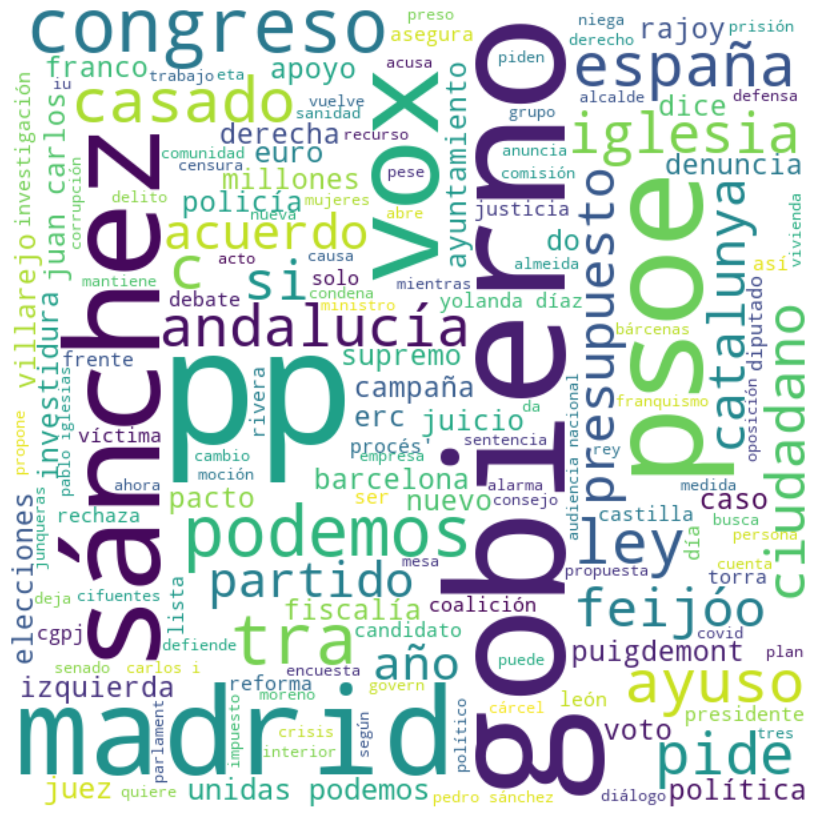

---------- Words for class: 0 ----------


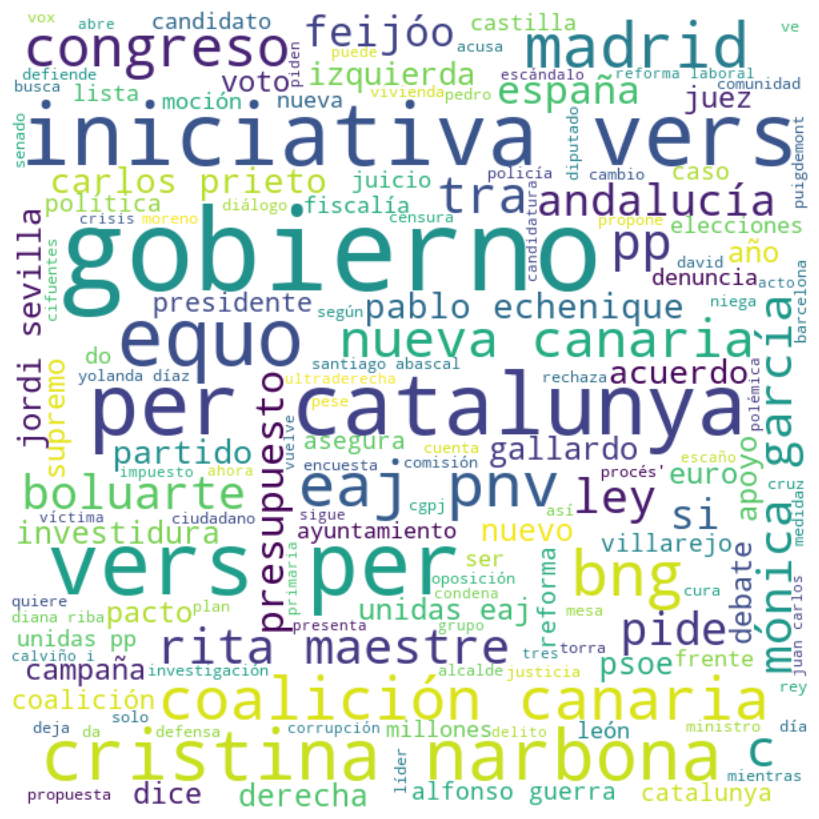

In [58]:
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['Label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['Label']==i,'Titulo'], stopwords=stop_words)

In [59]:
train

,ID,Label,Titulo,Descripcion,Fecha
0,ID,1,'The Guardian' va con Sánchez: 'Europa necesit...,El diario británico publicó este pasado jueves...,02/06/2023
1,ID,0,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...,01/10/2023
2,ID,1,El 'Ahora o nunca' de Joan Fuster sobre el est...,El valencianismo convoca en Castelló su fiesta...,25/04/2022
3,ID,1,"Iglesias alienta a Yolanda Díaz, ERC y EH Bild...","En política, igual que hay que negociar con lo...",03/01/2022
4,ID,0,Puigdemont: 'No sería ninguna tragedia una rep...,"En una entrevista en El Punt Avui, el líder de...",09/03/2018
...,...,...,...,...,...
57058,ID,1,El Defensor del Pueblo reclama a la Comunidad ...,El gobierno regional han indicado que la atenc...,08/06/2021
57059,ID,0,El EQUO plantea ceder la presidencia de la Com...,Si la higiene democrática nos lleva a esa exig...,08/09/2020
57060,ID,1,Alberto Garzón: 'Que los Borbones son unos lad...,El coordinador federal de IU asegura que la mo...,12/07/2018
57061,ID,1,Vox exige entrar en el Gobierno de Castilla y ...,Santiago Abascal: Vox tiene el derecho y el de...,13/02/2022


# Preparación de Datos


In [ ]:
X_train, y_train = train['Titulo'], train['Label']  
display(X_train)
y_train

0        'The Guardian' va con Sánchez: 'Europa necesit...
1        REVELAN QUE EL GOBIERNO NEGOCIO LA LIBERACIÓN ...
2        El 'Ahora o nunca' de Joan Fuster sobre el est...
3        Iglesias alienta a Yolanda Díaz, ERC y EH Bild...
4        Puigdemont: 'No sería ninguna tragedia una rep...
                               ...                        
57058    El Defensor del Pueblo reclama a la Comunidad ...
57059    El EQUO plantea ceder la presidencia de la Com...
57060    Alberto Garzón: 'Que los Borbones son unos lad...
57061    Vox exige entrar en el Gobierno de Castilla y ...
57062    Unas 300 personas protestan contra la visita d...
Name: Titulo, Length: 56618, dtype: object

0        1
1        0
2        1
3        1
4        0
        ..
57058    1
57059    0
57060    1
57061    1
57062    1
Name: Label, Length: 56618, dtype: int64

## Modificación de caracteres

Se pasan todos los caracteres a minuscula, se eliminan los textos de puntuación y asi mismo las stop words (que suelen ser palabras como articulos y conectores)

1. Cambiar a minusculas

In [61]:
def to_lower(words: list[str]):
    return [word.lower() for word in words]

2. Quitar puntuación

In [62]:
def remove_punctuation(words: list[str]):
    return [word for word in words if word.isalnum()]

3. Eliminar StopWords

In [63]:
def remove_stopwords(words: list[str]):
    stopwords = set(nltk.corpus.stopwords.words('spanish'))
    return [word for word in words if word not in stopwords]


In [64]:
def preprocessing(words):
    words = to_lower(words)
    words = remove_punctuation(words)
    words = remove_stopwords(words)
    return words

Ahora se va a hacer un procedimiento de Tokenizacion para desglozar las palabras

In [65]:
new_X_train = X_train.apply(word_tokenize)
new_X_train = new_X_train.apply(preprocessing) 
new_X_train.head()

0    [guardian, va, sánchez, necesita, apuesta, dé,...
1    [revelan, gobierno, negocio, liberación, mirel...
2    [nunca, joan, fuster, estatuto, valenciano, cu...
3    [iglesias, alienta, yolanda, díaz, erc, eh, bi...
4    [puigdemont, ninguna, tragedia, repetición, el...
Name: Titulo, dtype: object

In [66]:
def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = SnowballStemmer('spanish')
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

In [67]:

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


In [68]:
def stem_and_lemmatize(words):
    #words = stem_words(words)
    words = lemmatize_verbs(words)
    return words

In [69]:
new_X_train = new_X_train.apply(stem_and_lemmatize) 
new_X_train.head()

0    [guardian, va, sánchez, necesita, apuesta, dé,...
1    [revelan, gobierno, negocio, liberación, mirel...
2    [nunca, joan, fuster, estatuto, valenciano, cu...
3    [iglesias, alienta, yolanda, díaz, erc, eh, bi...
4    [puigdemont, ninguna, tragedia, repetición, el...
Name: Titulo, dtype: object

# Entrenamiento de un Decision Tree

In [ ]:
121# Import a decision tree
# # Split the data into a training and a test set

from sklearn.tree import DecisionTreeClassifier

# Assuming new_X_train and y_train are defined as in the provided code

# Convert the list of words back to strings
new_X_train = new_X_train.apply(lambda x: ' '.join(x))

# Split data into training and testing sets
X_train_split, X_test_split, y_train_split, y_test_split = train_test_split(
    new_X_train, y_train, test_size=0.2, random_state=42
)

# Create a TF-IDF vectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the training data
X_train_vec = vectorizer.fit_transform(X_train_split)

# Transform the testing data
X_test_vec = vectorizer.transform(X_test_split)


# Initialize and train a decision tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_vec, y_train_split)

# Make predictions
y_pred = dt_classifier.predict(X_test_vec)

# Evaluate the model
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Accuracy: {accuracy}")
print(classification_report(y_test_split, y_pred))


Accuracy: 0.7235075944895797
              precision    recall  f1-score   support

           0       0.66      0.73      0.69      4844
           1       0.78      0.72      0.75      6480

    accuracy                           0.72     11324
   macro avg       0.72      0.72      0.72     11324
weighted avg       0.73      0.72      0.72     11324



## Entrenamiento de un Random Forest

In [ ]:
#  Import a random forest
# # Create the random forest

from sklearn.ensemble import RandomForestClassifier

# Initialize and train a random forest classifier
rf_classifier = RandomForestClassifier(random_state=42)
rf_classifier.fit(X_train_vec, y_train_split)

# Make predictions
y_pred_rf = rf_classifier.predict(X_test_vec)

# Evaluate the model
accuracy_rf = accuracy_score(y_test_split, y_pred_rf)
print(f"Random Forest Accuracy: {accuracy_rf}")
print(classification_report(y_test_split, y_pred_rf))


Random Forest Accuracy: 0.7749028611797951
              precision    recall  f1-score   support

           0       0.76      0.68      0.72      4844
           1       0.78      0.84      0.81      6480

    accuracy                           0.77     11324
   macro avg       0.77      0.76      0.77     11324
weighted avg       0.77      0.77      0.77     11324



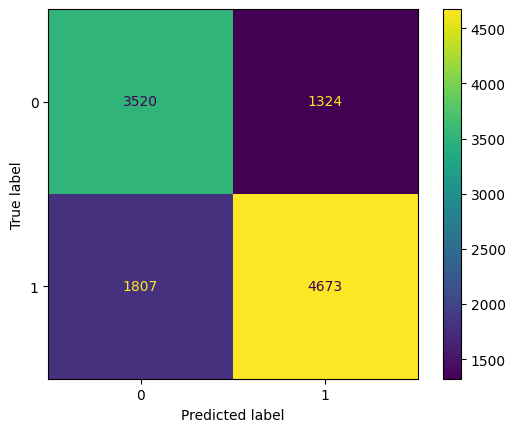

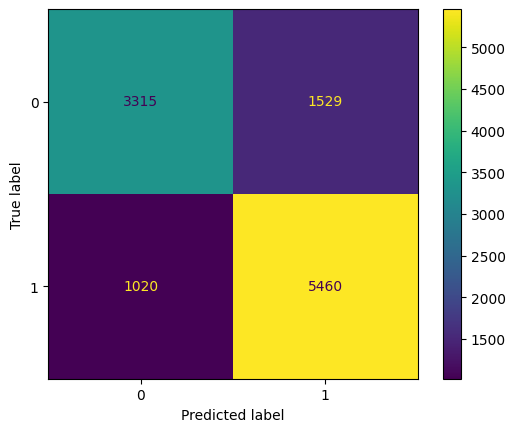

In [76]:
# Plot confussion matrix

import matplotlib.pyplot as plt
# Create the confusion matrix
cm = confusion_matrix(y_test_split, y_pred)

# Create the display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dt_classifier.classes_)

# Plot the confusion matrix
disp.plot()
plt.show()


# Create the confusion matrix for random forest
cm_rf = confusion_matrix(y_test_split, y_pred_rf)

# Create the display object for random forest
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=rf_classifier.classes_)

# Plot the confusion matrix for random forest
disp_rf.plot()
plt.show()


# Construccion de el pipeline de prediccion

In [77]:
#  Construccion de el pipeline de prediccion

import joblib

# Save the trained Decision Tree model
joblib.dump(dt_classifier, 'dt_classifier_model.pkl')

# Save the trained Random Forest model
joblib.dump(rf_classifier, 'rf_classifier_model.pkl')

# Save the vectorizer
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')


# Load the saved models and vectorizer
loaded_dt_classifier = joblib.load('dt_classifier_model.pkl')
loaded_rf_classifier = joblib.load('rf_classifier_model.pkl')
loaded_vectorizer = joblib.load('tfidf_vectorizer.pkl')


def predict_fake_news(text, model='dt'):
    # Preprocess the input text
    text = fix_encoding(text)
    tokenized_text = word_tokenize(text)
    processed_text = preprocessing(tokenized_text)
    processed_text = stem_and_lemmatize(processed_text)
    processed_text = ' '.join(processed_text)

    # Vectorize the input text
    vectorized_text = loaded_vectorizer.transform([processed_text])

    # Make a prediction
    if model == 'dt':
      prediction = loaded_dt_classifier.predict(vectorized_text)[0]
    elif model == 'rf':
      prediction = loaded_rf_classifier.predict(vectorized_text)[0]
    else:
      raise ValueError("Invalid model name. Choose 'dt' or 'rf'.")

    return prediction

# Example usage:
new_text = "Este es un titular de prueba."
prediction_dt = predict_fake_news(new_text, model='dt')
prediction_rf = predict_fake_news(new_text, model='rf')
print(f"Decision Tree Prediction for '{new_text}': {prediction_dt}")
print(f"Random Forest Prediction for '{new_text}': {prediction_rf}")


Decision Tree Prediction for 'Este es un titular de prueba.': 1
Random Forest Prediction for 'Este es un titular de prueba.': 1


Best Model Accuracy: 0.7875309078064289
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      4844
           1       0.73      0.99      0.84      6480

    accuracy                           0.79     11324
   macro avg       0.85      0.75      0.76     11324
weighted avg       0.83      0.79      0.77     11324



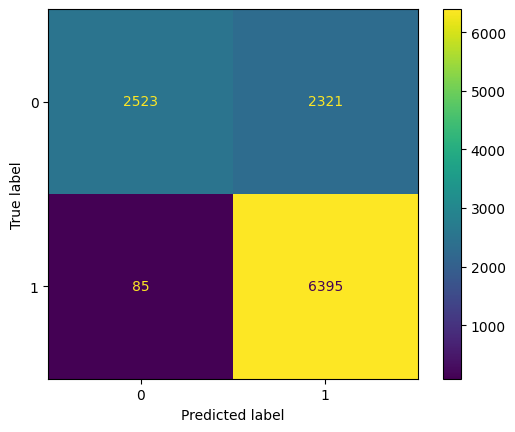

In [ ]:
# Prueba de pipeline con train-test split

import matplotlib.pyplot as plt
# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'dt__max_depth': [None, 10, 20],
    'dt__min_samples_split': [2, 5, 10]
}

# Create a KFold object for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(X_train_split, y_train_split)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_split)
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Best Model Accuracy: {accuracy}")
print(classification_report(y_test_split, y_pred))


# Create the confusion matrix
cm = confusion_matrix(y_test_split, y_pred)

# Create the display object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_model.classes_)

# Plot the confusion matrix
disp.plot()
plt.show()


In [87]:
datos_test = pd.read_csv(r'C:\Users\MarianaLozano\OneDrive - NOLDATA.CO\Documents\Universidad\Octavo semestre\BI\Proyecto1-BI\Etapa 1\datos\fake_news_test.csv', sep=';', encoding='utf-8')

In [89]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk

# Descargar stopwords de NLTK
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

# Crear la lista de stopwords en español
spanish_stop_words = stopwords.words('spanish')

# Simulación de datos para evitar el error si los textos están vacíos
new_X_train = datos_test['Titulo'].copy()

# Asegurar que los datos no están vacíos después del preprocesamiento
new_X_train = new_X_train.dropna()  # Eliminar valores NaN
new_X_train = new_X_train[new_X_train.str.strip() != ""]  # Eliminar espacios vacíos

# Evitar que todas las palabras sean eliminadas como stopwords
vectorizer = TfidfVectorizer(stop_words=spanish_stop_words, min_df=1)

# Verificar si hay texto después del preprocesamiento
if new_X_train.empty:
    raise ValueError("Error: El conjunto de datos está vacío después del preprocesamiento.")

# Transformar los textos a la representación TF-IDF
X_train_vec = vectorizer.fit_transform(new_X_train)

# Obtener las palabras más importantes
feature_names = vectorizer.get_feature_names_out()
idf_values = vectorizer.idf_

# Crear un DataFrame con palabras e IDF
idf_df = pd.DataFrame({'word': feature_names, 'idf': idf_values})

# Ordenar por IDF en orden descendente
idf_df = idf_df.sort_values(by='idf', ascending=False)

# Mostrar las 10 palabras con mayor IDF
top_n = 10
print(idf_df.head(top_n))


          word       idf
3789     único  7.214608
3783     óscar  7.214608
3781   órdenes  7.214608
3780   ómnibus  7.214608
3          107  7.214608
3764   zaplana  7.214608
3762    zamora  7.214608
3761  zaldibar  7.214608
3760   zalamea  7.214608
3759      york  7.214608


---------- Words for class: 1 ----------


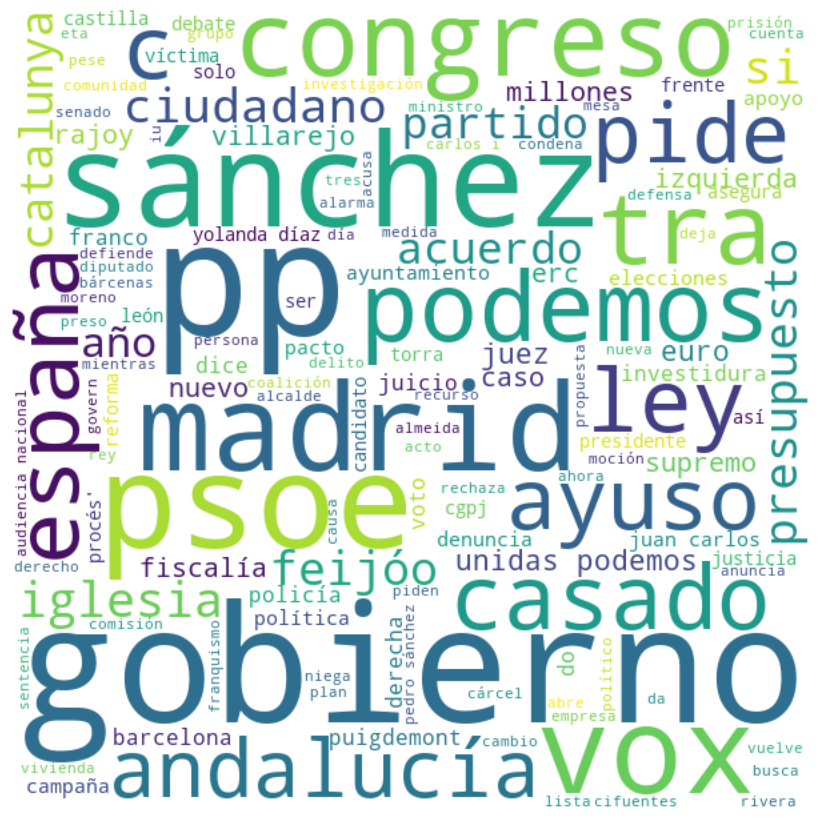

---------- Words for class: 0 ----------


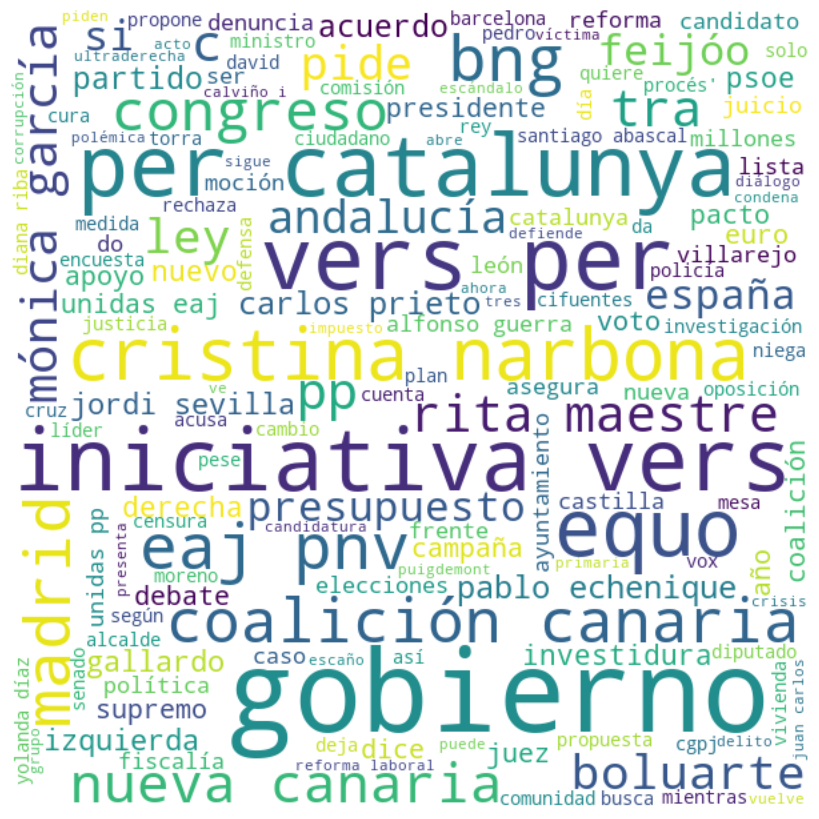

In [ ]:
# make a wordcloud

import matplotlib.pyplot as plt
def mostrar_grafico1(palabras,stopwords=[]):
    comment_words = ''
    
    # iterate through the csv file
    for val in palabras:
        
        # typecaste each val to string
        val = str(val)
    
        # split the value
        tokens = val.split()
        
        # Converts each token into lowercase
        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()
        
        comment_words += " ".join(tokens)+" "
    
    
    wordcloud = WordCloud(width = 600, height = 600,
                    background_color ='white',
                    stopwords = stopwords,
                    min_font_size = 10).generate(comment_words)
    
    # plot the WordCloud image                      
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad = 0)
    
    plt.show()

# Example usage (assuming 'train' DataFrame is defined as in your original code):
stop_words = set(nltk.corpus.stopwords.words('spanish'))

for i in train['Label'].unique():
    print(f'---------- Words for class: {i} ----------')
    mostrar_grafico1(train.loc[train['Label']==i,'Titulo'], stopwords=stop_words)


# Prueba de pipeline con CV y gridsearch

In [ ]:
# Prueba de pipeline con CV y gridsearch



# Create a pipeline
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'dt__max_depth': [None, 10, 20],
    'dt__min_samples_split': [2, 5, 10]
}

# Create a KFold object for cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring='accuracy')
grid_search.fit(X_train_split, y_train_split)

# Get the best model
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test_split)
accuracy = accuracy_score(y_test_split, y_pred)
print(f"Best Model Accuracy: {accuracy}")
print(classification_report(y_test_split, y_pred))



Best Model Accuracy: 0.7884139879901095
              precision    recall  f1-score   support

           0       0.97      0.52      0.68      4844
           1       0.73      0.99      0.84      6480

    accuracy                           0.79     11324
   macro avg       0.85      0.75      0.76     11324
weighted avg       0.84      0.79      0.77     11324



# Prueba de pipeline con dataset de prueba final y exportacion de csv / xlsx resultante

In [94]:
!pip install openpyxl


  Using cached openpyxl-3.1.5-py2.py3-none-any.whl.metadata (2.5 kB)
Using cached openpyxl-3.1.5-py2.py3-none-any.whl (250 kB)



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [95]:
#  Prueba de pipeline con dataset de prueba final y exportacion de csv / xlsx resultante

import pandas as pd


# Create a DataFrame with the predictions and true labels
results_df = pd.DataFrame({'True Label': y_test_split, 'Predicted Label': y_pred})

# Export the results to a CSV file
results_df.to_csv('predictions.csv', index=False)

# Export the results to an Excel file (requires openpyxl)
results_df.to_excel('predictions.xlsx', index=False, engine='openpyxl')
